In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df=pd.read_csv("BHARTIARTL.NS.csv")
df.head()

Date       Open       High        Low      Close  Adj Close  \
0  2002-07-01  15.343904  15.997316  15.096059  15.681876  14.616557   
1  2002-07-02  15.096059  16.042379  15.096059  15.997316  14.910567   
2  2002-07-03  16.222630  16.222630  15.749470  15.839596  14.763563   
3  2002-07-04  16.109974  16.335287  15.884659  16.222630  15.120577   
4  2002-07-05  15.794533  15.974785  15.321373  15.411499  14.364548   

      Volume  
0   847376.0  
1   676474.0  
2   574661.0  
3  1148300.0  
4   903273.0

In [3]:
df.dropna(inplace=True)

In [4]:
from sklearn.model_selection import train_test_split
features = ["Open", "High", "Low", "Volume"]
target = "Close"

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2)

In [5]:
X_train.columns

Index(['Open', 'High', 'Low', 'Volume'], dtype='object')

In [6]:
X_test.columns

Index(['Open', 'High', 'Low', 'Volume'], dtype='object')

In [7]:
X_train.isnull().sum()

Open      0
High      0
Low       0
Volume    0
dtype: int64

In [8]:
accuracies=[]
maes=[]
mses=[]

### Decision Tree

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

model = DecisionTreeRegressor()
param_grid = {
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 8]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


# Evaluate the model
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracies.append(r2)
mses.append(mse)
maes.append(mae)

# Print the results
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)

Best parameters: {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best score: -27.222949056955127
Mean Squared Error (MSE): 28.14037384517932
Mean Absolute Error (MAE): 3.2700352259398975
R-squared: 0.9993854064411063


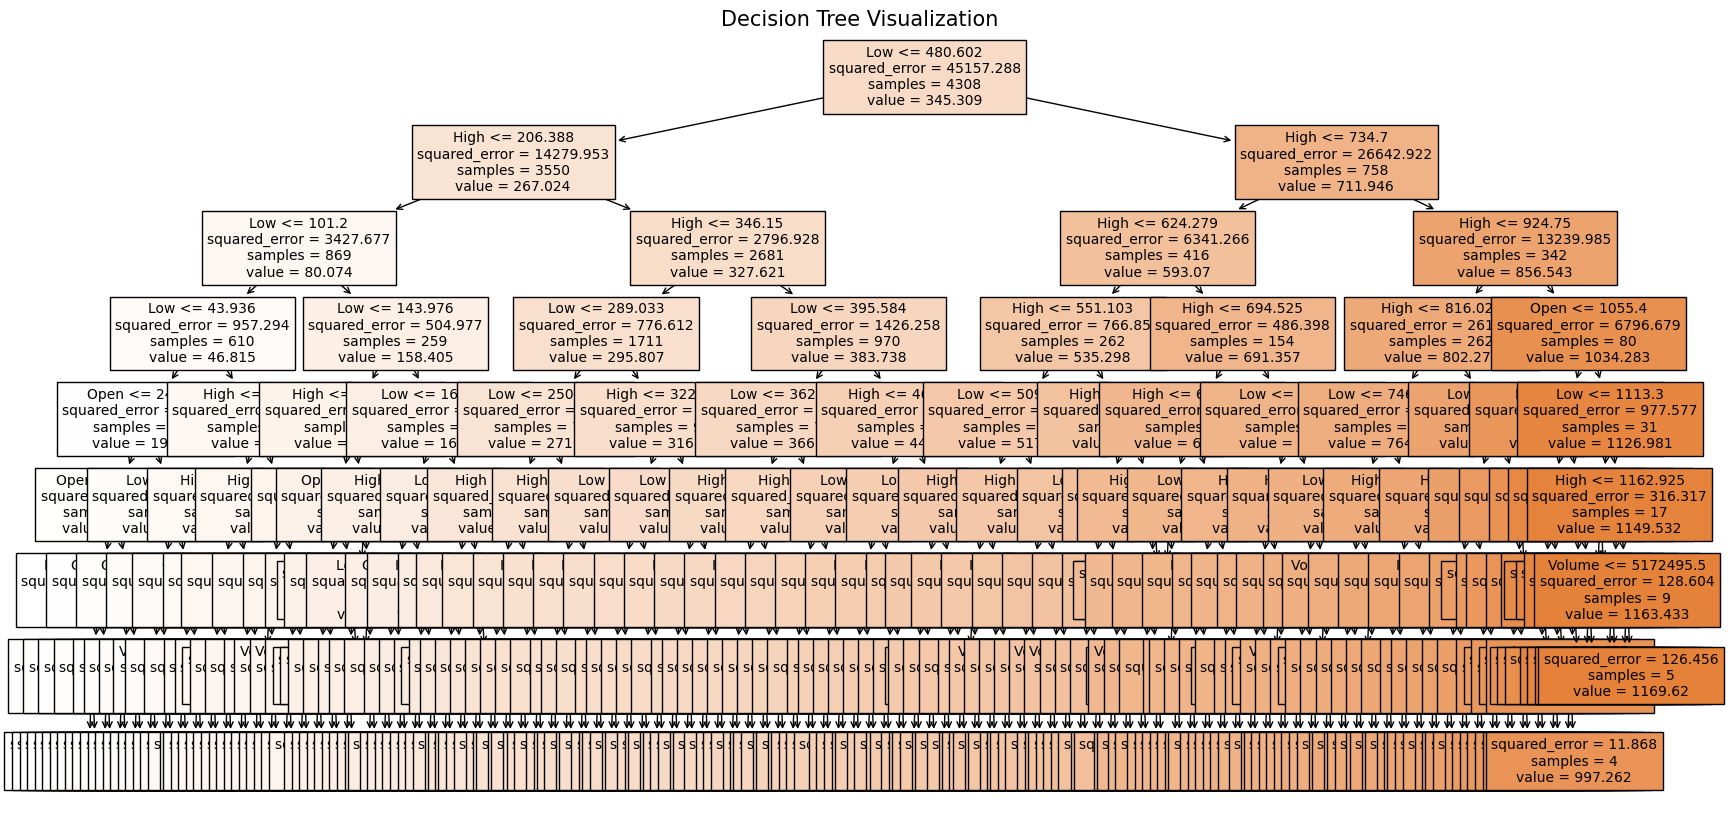

In [10]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

best_tree = grid_search.best_estimator_

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X_train.columns, filled=True, fontsize=10)
plt.title("Decision Tree Visualization", fontsize=15)
plt.show()


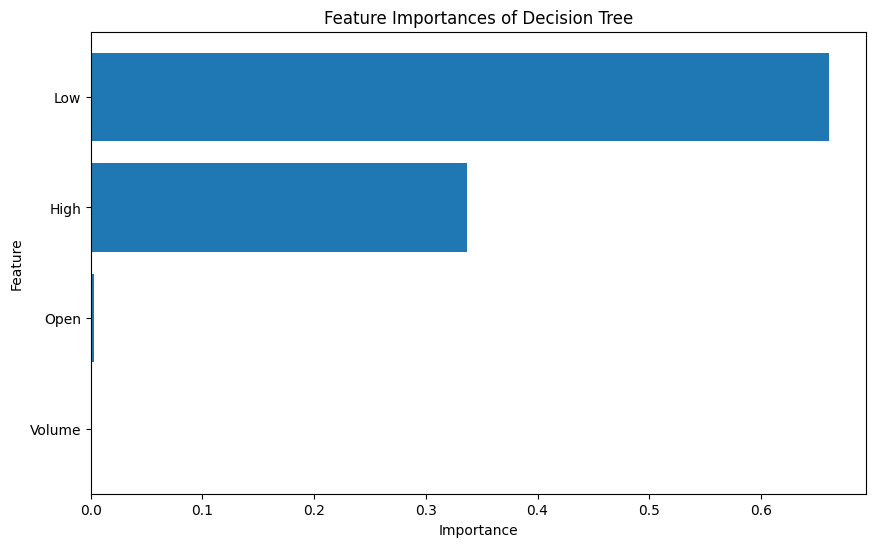

In [11]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

model = DecisionTreeRegressor()
model.fit(X_train, y_train)


importances = model.feature_importances_
feature_names = X_train.columns


indices = np.argsort(importances)[::-1]
feature_names_sorted = feature_names[indices]
importances_sorted = importances[indices]

# Create a bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_names_sorted, importances_sorted)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances of Decision Tree")
plt.gca().invert_yaxis()  
plt.show()


### Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestRegressor()
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 8]
}

rand_search = RandomizedSearchCV(model, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error')
rand_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", rand_search.best_params_)
print("Best score:", rand_search.best_score_)

# Evaluate the model
y_pred = rand_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracies.append(r2)
mses.append(mse)
maes.append(mae)

# Print the results
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)


Best parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5}
Best score: -49.82025334213331
Mean Squared Error (MSE): 51.2488334274313
Mean Absolute Error (MAE): 5.3043939568060905
R-squared: 0.9988807112834178


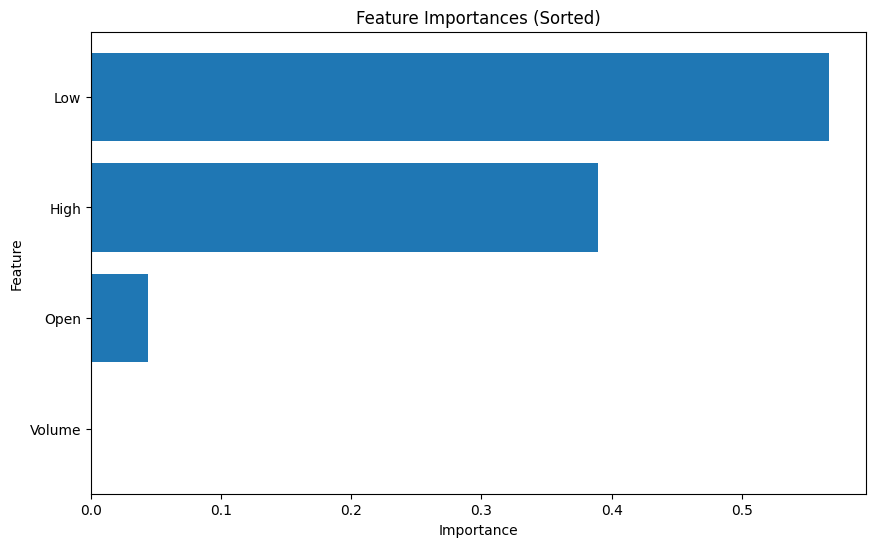

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Get importances and feature names
importances = rand_search.best_estimator_.feature_importances_
feature_names = X_train.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]
feature_names_sorted = feature_names[indices]
importances_sorted = importances[indices]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_names_sorted, importances_sorted)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances (Sorted)")
plt.gca().invert_yaxis()  # Invert y-axis to display most important on top
plt.show()


/Users/parimal/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


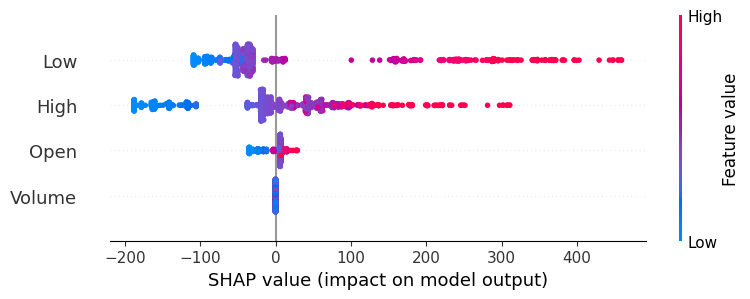

In [14]:
import shap

explainer = shap.TreeExplainer(rand_search.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])
shap.summary_plot(shap_values, X_test)

**Feature Names (y-axis):** These are the names of the features used by the model to predict stock prices. In this case, they seem to be "Open", "High", "Low", and "Volume".<br>
**SHAP value (x-axis):** This represents the feature's impact on the model's prediction. A positive value indicates that the feature increases the predicted stock price, while a negative value indicates that it decreases the predicted price. The magnitude of the value represents the strength of the impact.<br>
**Color:** The color of the bar indicates the direction of the impact. 

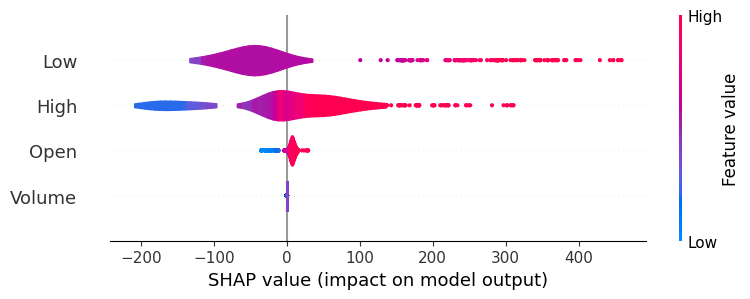

In [15]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="violin")

**Summary plot:** Shows the average impact of each feature.<br>
**Violin plot:** Shows the distribution of SHAP values for each feature, including how much they vary across data points.

In [16]:
import shap
shap.initjs()
shap_values = explainer(X_test)
shap.force_plot(shap_values[0], X_test.iloc[0], feature_names=X_test.columns[0:4])

**Base Value (leftmost bar):** This represents the model's average prediction without considering any specific features of the data point. It's like a starting point for the prediction.<br>
**Feature Bars:** Each subsequent bar represents a feature and its contribution to the final prediction. The position (left or right) indicates whether the feature's impact is positive (increasing price) or negative (decreasing price).<br>
**Color:** Similar to the summary plot, the color scheme (which might vary depending on the tool used) helps visualize the direction of the impact. Generally, red or orange represents a positive impact, and blue or purple represents a negative impact.<br>
**Final Prediction (rightmost bar):** This bar shows the model's final prediction for the specific data point, which is the sum of the base value and all the individual feature contributions.

In [17]:
import lime 

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=features, mode='regression')
instance_index = 0
instance = X_test.iloc[[instance_index]].values[0]
explanation = explainer.explain_instance(instance, rand_search.best_estimator_.predict)

# Print the explanation
explanation.show_in_notebook()


/Users/parimal/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


**Predicted value:** This row shows the range of possible predicted values. The minimum value is -13.89 and the maximum value is 759.33.<br>
**Feature:** This column lists the features that the model used to make a prediction.<br>
**Value:** This column shows the value of each feature used in the model's prediction.<br>
**Low > 378.16:** This section shows the impact of having a feature value higher than 378.16. For the “Low” feature, a value higher than 378.16 increases the prediction by 214.40.<br>
**High > 390.70:** This section shows the impact of having a feature value higher than 390.70. For the “High” feature, a value higher than 390.70 increases the prediction by 203.04.<br>
**Open > 385.29:** This section shows the impact of having a feature value higher than 385.29. It seems like the value for this feature (Open) is 768.00, which increases the prediction by an unknown value since it’s greater than the threshold value of 385.29.<br>
**11.18 < Volume < 2863964.50:** This section shows the impact of having a feature value within the range of 11.18 and 2,863,964.50. It seems like the value for this feature (Volume) is 3,197,932.00, which falls outside the specified range. How it affects the prediction is unclear based on this information.

### XGBoost

In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

model = XGBRegressor()
param_grid = {
  'max_depth': [3, 5, 8],
  'n_estimators': [100, 200, 500]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

importances = grid_search.best_estimator_.feature_importances_
feature_names = X_train.columns

# Print feature importances
for feature, importance in zip(feature_names, importances):
  print(f"{feature}: {importance:.4f}")

y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracies.append(r2)
mses.append(mse)
maes.append(mae)

# Print the results
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)

Best parameters: {'max_depth': 3, 'n_estimators': 200}
Best score: -29.108474572230488
Open: 0.0014
High: 0.4108
Low: 0.5877
Volume: 0.0001
Mean Squared Error (MSE): 32.858825434867775
Mean Absolute Error (MAE): 3.2620863372375997
R-squared: 0.9992823541515053


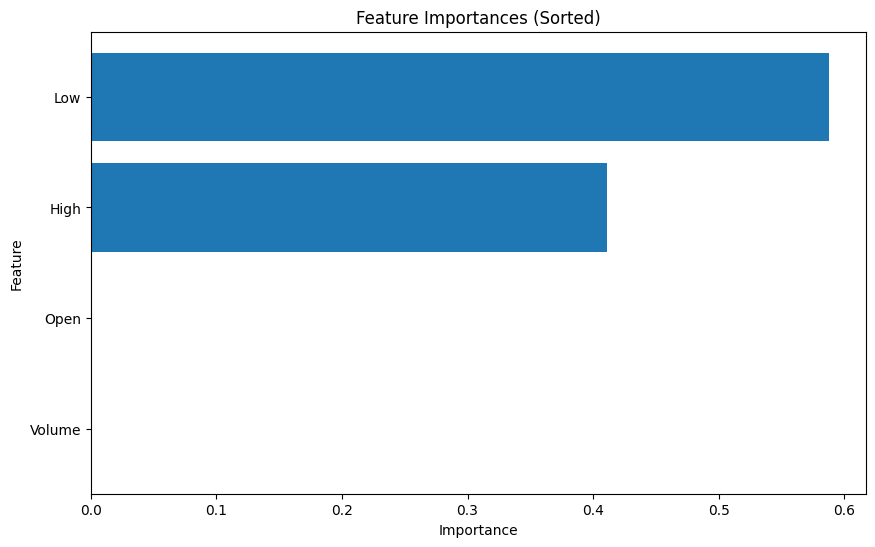

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Get importances and feature names
importances = grid_search.best_estimator_.feature_importances_
feature_names = X_train.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]
feature_names_sorted = feature_names[indices]
importances_sorted = importances[indices]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_names_sorted, importances_sorted)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances (Sorted)")
plt.gca().invert_yaxis()  # Invert y-axis to display most important on top
plt.show()


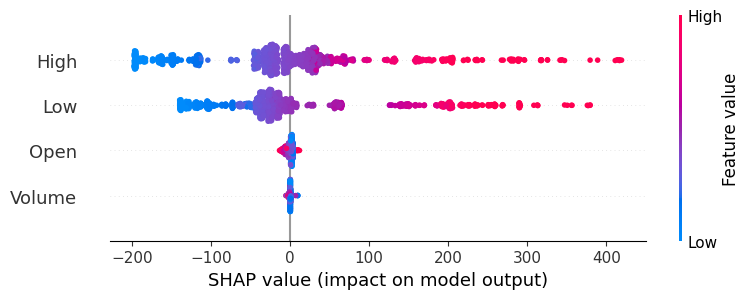

In [20]:
import shap

explainer = shap.TreeExplainer(grid_search.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])
shap.summary_plot(shap_values, X_test)

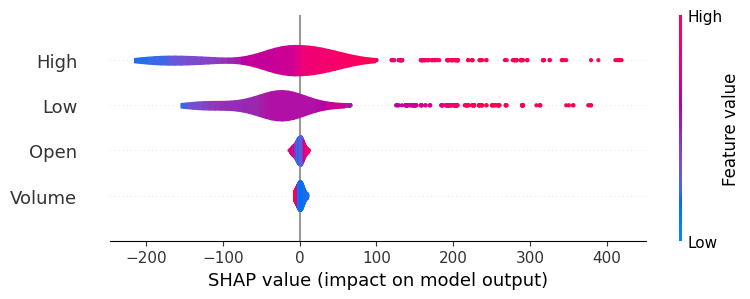

In [21]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="violin")

In [22]:
import shap
shap.initjs()
shap_values = explainer(X_test)
shap.force_plot(shap_values[0], X_test.iloc[0], feature_names=X_test.columns[0:4])

In [23]:
import lime

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=features, mode='regression')
instance_index = 0
instance = X_test.iloc[[instance_index]].values[0]
explanation = explainer.explain_instance(instance, grid_search.best_estimator_.predict)

# Print the explanation
explanation.show_in_notebook()


### Performance Comparison

In [24]:
models = ['Decision Tree', 'Random Forest', 'XGBoost']

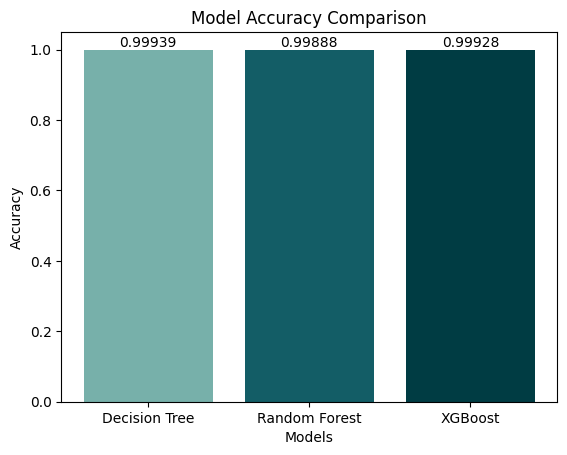

In [25]:
colors = ['#77B0AA', '#135D66', '#003C43']
for i in range(len(models)):
    plt.text(i, accuracies[i], f'{accuracies[i]:.5f}', ha='center', va='bottom')
plt.bar(models, accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()


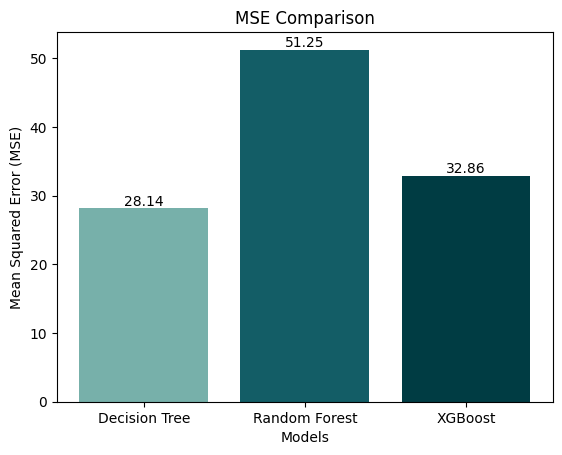

In [26]:
for i in range(len(models)):
    plt.text(i, mses[i], f'{mses[i]:.2f}', ha='center', va='bottom')
plt.bar(models, mses, color=colors)
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Comparison')
plt.show()


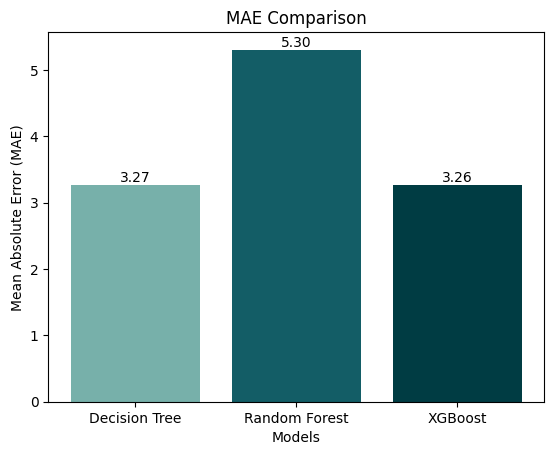

In [27]:
for i in range(len(models)):
    plt.text(i, maes[i], f'{maes[i]:.2f}', ha='center', va='bottom')
plt.bar(models, maes, color=colors)
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE Comparison')
plt.show()


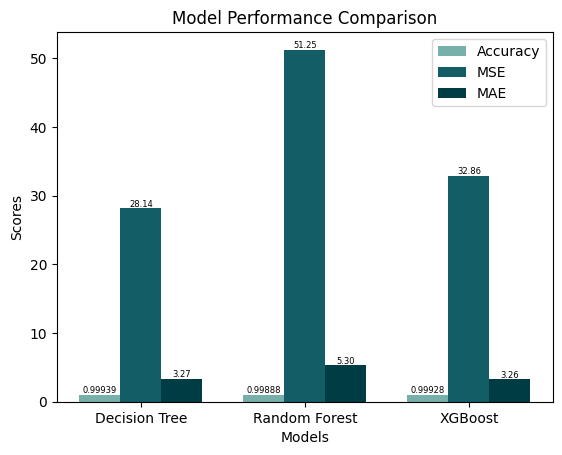

In [28]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(models))  # X-axis positions for the groups
width = 0.25  # Width of the bars

# Plot the bars for each metric
plt.bar(x - width, accuracies, width, label='Accuracy', color='#77B0AA')
plt.bar(x, mses, width, label='MSE', color='#135D66')
plt.bar(x + width, maes, width, label='MAE', color='#003C43')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x, models)  # Set x-axis tick labels
plt.legend()  # Add a legend

# Show the values on top of the bars
for i in range(len(models)):
    plt.text(x[i] - width, accuracies[i], f'{accuracies[i]:.5f}', ha='center', va='bottom', fontsize=6)
    plt.text(x[i], mses[i], f'{mses[i]:.2f}', ha='center', va='bottom',fontsize=6)
    plt.text(x[i] + width, maes[i], f'{maes[i]:.2f}', ha='center', va='bottom',fontsize=6)

# Display the plot
plt.show()
